In [121]:
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np 
import xgboost as xgb
from matplotlib.offsetbox import AnchoredText
import heapq
import math 
from nasspython.nass_api import nass_data
from NdviApi import NDVI

In [122]:
plt.style.use('ggplot')

In [123]:
""" 
Helpful Links:
https://geo.fas.usda.gov/GADAS/index.html#
https://glam1.gsfc.nasa.gov/
https://www.mdpi.com/2072-4292/13/21/4227
https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
"""

' \nHelpful Links:\nhttps://geo.fas.usda.gov/GADAS/index.html#\nhttps://glam1.gsfc.nasa.gov/\nhttps://www.mdpi.com/2072-4292/13/21/4227\nhttps://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db\n'

In [124]:

# Generic function to initialize dataframes from USDA Quickstats data
def initialize_df(states, week, start_yr, end_yr, freq, suffix, var):
    temp = pd.DataFrame(nass_data("B3744D45-DFBE-3B88-AFB1-25CBC8E64550", agg_level_desc="STATE", freq_desc=freq, short_desc=var)['data'])
    temp = temp[temp["state_name"].isin(states)]
    if (freq == "WEEKLY"):
        temp = temp[temp["reference_period_desc"].eq(f"WEEK #{week}")]
    elif (freq == "ANNUAL"):
        temp = temp[temp["reference_period_desc"].eq("YEAR")]
    temp = temp[temp["year"].ge(start_yr) & temp["year"].le(end_yr)]
    temp = temp.pivot(index='year', columns='state_name', values="Value")
    temp = temp.add_suffix(suffix)
    temp = temp.replace(",", "", regex=True)
    temp = temp.fillna(0).astype(float)
    return temp 

In [125]:

# NDVI data via https://glam1.gsfc.nasa.gov/
def get_ndvi_data(states, ids, mask, threshold, index):
    acc_ndvi_df = pd.DataFrame(index=index)
    for i in range(len(ids)):
        acc_ndvi = list()
        df = NDVI().get_data(
                            version='v15', 
                            sat='MOD',
                            mask=mask, 
                            shape='ADM',
                            start_yr=2000,
                            end_yr=2023,
                            start_month=1,
                            num_months=12,
                            ids=ids[i],
                            ts_type='cumulative',
                            mcv=0.0
                            )
        count=0
        for j in range(df.shape[0]):
            if (int(df.loc[j, "ORDINAL DATE"][-3:]) == 329):
                acc_ndvi.append(count)
                count=0
            elif (df.loc[j, "SAMPLE VALUE"] >= threshold): 
                count+=df.loc[j, "SAMPLE VALUE"] 
        acc_ndvi_df["NDVI " + states[i]] = acc_ndvi  
    return acc_ndvi_df

In [126]:

# Drought index data from https://droughtmonitor.unl.edu/About.aspx
def get_drought_data(states, ids, start_yr, end_yr, index):
    drought_data = pd.DataFrame(index=index)
    for i in range (len(ids)):
        if len(str(ids[i])) == 1:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi=0{ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        else:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi={ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        df = df.loc[:, ["ValidStart", "None", "D0", "D1", "D2", "D3", "D4"]]
        df["ValidStart"] = pd.to_datetime(df["ValidStart"]).dt.to_period('Y')
        df = df.iloc[::-1].set_index("ValidStart", drop=True)
        df = df.replace(",", "", regex=True)
        df = df.fillna(0).astype(float)
        df = df.groupby(lambda x: x.year)[["None", "D0", "D1", "D2", "D3", "D4"]].mean()
        df.index.name = None
        df = df.add_prefix(f"{states[i]} ")
        drought_data = pd.concat([drought_data, df], axis=1)
    return drought_data

In [127]:
"""
Function to initialize data

Pass crop, week to take data from, and array of 1s and 0s indicating which additional variables to include.

Available crops are "CORN", "WHEAT, WINTER" and "SOYBEAN"

Below are the available variables, in order:
1. PCT Excellent at current week
2. PCT Good at current week
3. PCT Change in Excellent (pct @ week - pct @ week - 10)
4. PCT Change in Good (pct @ week - pct @ week - 10)
5. Acres planted/year
6. Acres harvested at current week
7. PCT Mature at current week
8. Drought data

Sample input below
"""


def get_data(crop, week, start_yr=2000, end_yr=2023, var_arr=[]):
    
    if (crop == "CORN"):
        mask = "USDA-NASS-CDL_2018-2023_corn-50pp"
        states = ["WISCONSIN", "SOUTH DAKOTA", "OHIO", "NEBRASKA", "MISSOURI", "MINNESOTA", "KANSAS", "IOWA", "INDIANA", "ILLINOIS"]
        ndvi_ids = [26264, 26237, 26258, 26228, 26253, 26251, 26226, 26246, 26245, 26244]
        drought_ids = [55, 46, 39, 31, 29, 27, 20, 19, 18, 17]
        threshold = 0.58
    elif (crop == "SOYBEANS"):
        mask = "USDA-NASS-CDL_2018-2023_soybean-50pp"
        states = ["SOUTH DAKOTA", "OHIO", "NORTH DAKOTA", "NEBRASKA", "MISSOURI", "MINNESOTA", "IOWA", "INDIANA", "ILLINOIS", "ARKANSAS"]
        ndvi_ids = [26237, 26258, 26236, 26228, 26253, 26251, 26246, 26245, 26244, 26240]
        drought_ids = [46, 39, 38, 31, 29, 27, 19, 18, 17, 5]
        threshold = 0.58
    elif (crop == "WHEAT, WINTER"):
        mask = "USDA-NASS-CDL_2018-2023_winterwheat-50pp"
        states = ["WASHINGTON", "SOUTH DAKOTA", "OKLAHOMA", "NEBRASKA", "MONTANA", "MISSOURI", "KANSAS", "ILLINOIS", "IDAHO", "COLORADO"]
        ndvi_ids = [26234, 26237, 26230, 26228, 26227, 26253, 26226, 26244, 26225, 26224]
        drought_ids = [53, 46, 40, 31, 30, 29, 20, 17, 16, 8]
        threshold = 0.34

    idx = list(range(start_yr, end_yr + 1))
    """
    Get crop mask from: https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
    """
    df = get_ndvi_data(states, ndvi_ids, mask=mask, threshold=threshold, index=idx)
    
    if (crop == "CORN"):
        yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", "CORN, GRAIN - YIELD, MEASURED IN BU / ACRE")
    else:
        yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", f"{crop} - YIELD, MEASURED IN BU / ACRE")

    overlay = pd.DataFrame()
    
    additional_vars = {
                    0: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    1: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    2: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    3: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    4: "PCT CHNGE EXCELLENT",
                    5: "PCT CHNGE GOOD",
                    6: f"{crop} - ACRES PLANTED",
                    7: f"{crop} - PROGRESS, MEASURED IN PCT HARVESTED",
                    8: f"{crop} - PROGRESS, MEASURED IN PCT MATURE",
                    9: "Drought data" 
    }

    for i in range(8):
        if var_arr[i] == 1:
            if i == 2:
                excellent_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " EXCELLENT PCT CHNGE", additional_vars[i])
                excellent_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " EXCELLENT PCT CHNGE", additional_vars[i])
                pct_chnge_excellent = excellent_34 - excellent_24
                overlay = pd.concat([overlay, pct_chnge_excellent], axis=1)
            elif i == 3:
                good_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " GOOD PCT CHNGE", additional_vars[i])
                good_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " GOOD PCT CHNGE", additional_vars[i])
                pct_chnge_good = good_34 - good_24
                overlay = pd.concat([overlay, pct_chnge_good], axis=1)
            elif i == 4:
                planted = initialize_df(states, None, start_yr, end_yr, "ANNUAL", " ACRES PLANTED", additional_vars[6])
                overlay = pd.concat([overlay, planted], axis=1)
            elif i == 5:
                if (crop == "CORN"):
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", "CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED")
                else:
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", additional_vars[7])
                overlay = pd.concat([overlay, harvested], axis=1)
            elif i == 6:
                maturity = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT MATURE", additional_vars[8])
                overlay = pd.concat([overlay, maturity], axis=1)
            elif i == 7:
                drought_index = get_drought_data(states, drought_ids, 2000, 2023, idx)
                overlay = pd.concat([overlay, drought_index], axis=1)
            elif i == 0:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT EXCELLENT", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)   
            elif i == 1:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT GOOD", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)

    
    x = pd.concat([df, overlay], axis=1)
    x.fillna(0, inplace=True)
    cols = x.columns
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=cols)
    
    return yields, x

y, x = get_data("SOYBEANS", 43, 2000, 2023, [1, 1, 1, 1, 1, 1, 1, 1])


x.head()


,NDVI SOUTH DAKOTA,NDVI OHIO,NDVI NORTH DAKOTA,NDVI NEBRASKA,NDVI MISSOURI,NDVI MINNESOTA,NDVI IOWA,NDVI INDIANA,NDVI ILLINOIS,NDVI ARKANSAS,...,ILLINOIS D1,ILLINOIS D2,ILLINOIS D3,ILLINOIS D4,ARKANSAS None,ARKANSAS D0,ARKANSAS D1,ARKANSAS D2,ARKANSAS D3,ARKANSAS D4
0,0.543658,0.860853,0.570590,0.000000,0.309908,0.380263,0.260496,0.707888,0.419890,0.000000,...,0.833463,0.390822,0.0,0.0,0.138677,0.861323,0.665549,0.435228,0.280427,0.04655
1,0.075099,0.499072,0.000000,0.318474,0.461982,0.000000,0.481538,0.354093,0.576059,0.481136,...,0.102602,0.043187,0.0,0.0,0.622004,0.377996,0.194286,0.069205,0.000000,0.00000
2,0.187567,0.000000,0.686050,0.060824,0.043011,0.684649,0.514416,0.000000,0.000000,0.490901,...,0.160884,0.011395,0.0,0.0,0.847832,0.152168,0.023311,0.000000,0.000000,0.00000
3,0.000000,0.838325,0.500978,0.395920,0.460061,0.308333,0.087506,0.612693,0.277348,0.481136,...,0.519172,0.318498,0.0,0.0,0.788815,0.211185,0.034044,0.000000,0.000000,0.00000
4,0.551922,0.998145,0.705619,0.611636,1.000000,0.677632,1.000000,0.733986,0.663720,0.537949,...,0.000008,0.000000,0.0,0.0,0.867412,0.132588,0.033455,0.000000,0.000000,0.00000


In [128]:

# Extra Vegetation Health index (VHI) data for corn (just call the function if you want it). Taken out due to noise

vhi_links = ["https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=14&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=15&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=16&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=17&country=USA&yearlyTag=Yearly&type=Parea_VCI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=24&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=26&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=28&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=36&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=42&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=50&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024"]

def get_vhi_data(links):
    for i in range(len(links)):
        global x 
        vhi = pd.read_csv(links[i], skiprows=3)
        vhi = vhi.iloc[list(range(17, 41)), :]
        vhi.reset_index(inplace=True)
        vhi.set_index(vhi.columns[1], drop=True, inplace=True)
        vhi.drop(columns="index", inplace=True)
        vhi.index.name = None
        VHI_bins = list(range(0, 105, 5))
        vhi.drop(columns="Unnamed: 22", inplace=True)
        vhi.columns = VHI_bins
        vhi = vhi.add_prefix(y.columns[i] + " VHI Bin")
        vhi.index = x.index 
        x = pd.concat([x, vhi], axis=1)

In [129]:

# Returns feature coefficients
def feature_importance(model, df, ax, num_features, plot=False, print_results=False):
        importance = model.coef_
        keys = list(df.keys())
        abs_weights = {}
        weights = {}
        for i,v in enumerate(importance):
            if print_results:
                print("Feature: %s, Score: %.5f" % (keys[i],v))
            abs_weights[keys[i]] = abs(v)
            weights[keys[i]] = v
        if plot:
            ax.bar([x for x in range(len(importance))], height=importance, color='b')
            tickvals = range(0, len(importance))
            cols = df.columns
            ax.set_xticks(ticks=tickvals, labels=cols, rotation=45, fontsize='xx-small', fontstretch='extra-condensed')
        
        largest_features = heapq.nlargest(num_features, abs_weights, key=abs_weights.get)

        avg_abs_weight = sum([abs_weights.get(key) for key in largest_features]) / len(largest_features)
        return largest_features, weights, avg_abs_weight

In [130]:

# Returns optimized model based on RandomSearchCV and specified parameters.

def get_best_model(X, y, kwargs=None, lasso=True):
    xgb_params = {
    "learning_rate": np.arange(0.01, 0.2, 0.01),
    "min_child_weight": np.arange(1, 5, 1),
    "n_estimators": range(800, 1200),
    "max_depth": range(1, 5),
    "colsample_bytree": np.arange(0.1, 1, 0.1),
    "subsample": np.arange(0.1, 1, 0.1)
    }

    lasso_params = {
        "alpha": np.arange(0.05, 2, 0.05)
    }

    if not lasso:
        optimized_model = RandomizedSearchCV(param_distributions=xgb_params, estimator=xgb.XGBRegressor(**kwargs), scoring='neg_mean_absolute_error', verbose=1, random_state=42, cv=2)
        optimized_model.fit(X, y)
        print("Best Parameters:", optimized_model.best_params_)
    else: 
        optimized_model = RandomizedSearchCV(param_distributions=lasso_params, estimator=Lasso(random_state=42), scoring='neg_mean_absolute_error', verbose=1, random_state=42)
        optimized_model.fit(X, y)
        print("Best Parameters:", optimized_model.best_params_)
    return optimized_model

In [131]:
# Fitting models, analyzing and plotting data

def reg_plot(x, y, title, ax=None):
    X_train = x.iloc[0:15]
    X_test = x.iloc[15:20]
    X_cv = x.iloc[20:]
    y_train = y.iloc[0:15]
    y_test = y.iloc[15:20]
    y_cv = y.iloc[20:]


    # For most crops, a lower alpha (<= 0.7) is best. Higher alphas run the risk of reducing all coefficients to 0
    model = Lasso(alpha=0.45, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    weighted_features, weights, avg_abs_weight = feature_importance(model, X_train, ax, math.ceil(X_train.shape[1]/2))

    residuals = y_train - y_train_pred[0]
    residuals = pd.DataFrame(residuals, index=y_train.index)

    monotone_csts = np.zeros(len(weighted_features))
    monotone_csts = np.array(monotone_csts, dtype=int)
    for i in range(len(weighted_features)):

        if weights[weighted_features[i]] < 0 and abs(weights[weighted_features[i]]) > avg_abs_weight:
            monotone_csts[i] = -1
        elif weights[weighted_features[i]] > 0 and weights[weighted_features[i]] > avg_abs_weight:
            monotone_csts[i] = 1

    kwargs = {
        "monotone_constraints": f"{tuple(monotone_csts)}"
    }

    resid_model = xgb.XGBRegressor(
                                   max_depth=4,
                                   colsample_bytree=0.5,
                                   min_child_weight=2,
                                   **kwargs)
    resid_model.fit(X_train.loc[:, weighted_features], residuals)

    ax.scatter(y_train.index, y_train)
    ax.plot(y_train.index, y_train_pred)
    pred2 = resid_model.predict(X_test.loc[:, weighted_features]) + y_test_pred
    pred2 = pd.DataFrame(pred2, index=y_test.index)
    ax.scatter(y_test.index, y_test)
    ax.plot(y_test.index, pred2)
    
    resid_cv = y_test - y_test_pred
    resid_cv = pd.DataFrame(resid_cv, index=y_test.index)

    resid_cv_model = xgb.XGBRegressor(
                                   max_depth=4,
                                   colsample_bytree=0.5,
                                   min_child_weight=2,
                                   **kwargs)
    resid_cv_model.fit(X_test.loc[:, weighted_features], resid_cv)
    resid_cv_pred = resid_cv_model.predict(X_cv.loc[:, weighted_features])
    pred3 = model.predict(X_cv)

    pred3 = resid_cv_pred + pred3
    pred3 = pd.DataFrame(pred3, index=y_cv.index)
    ax.scatter(y_cv.index, y_cv)
    ax.plot(y_cv.index, pred3)

    ax.set_title(title)

    s = mean_absolute_error(y_cv, pred3)
    at = AnchoredText(
        f"{s:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

    return ax 

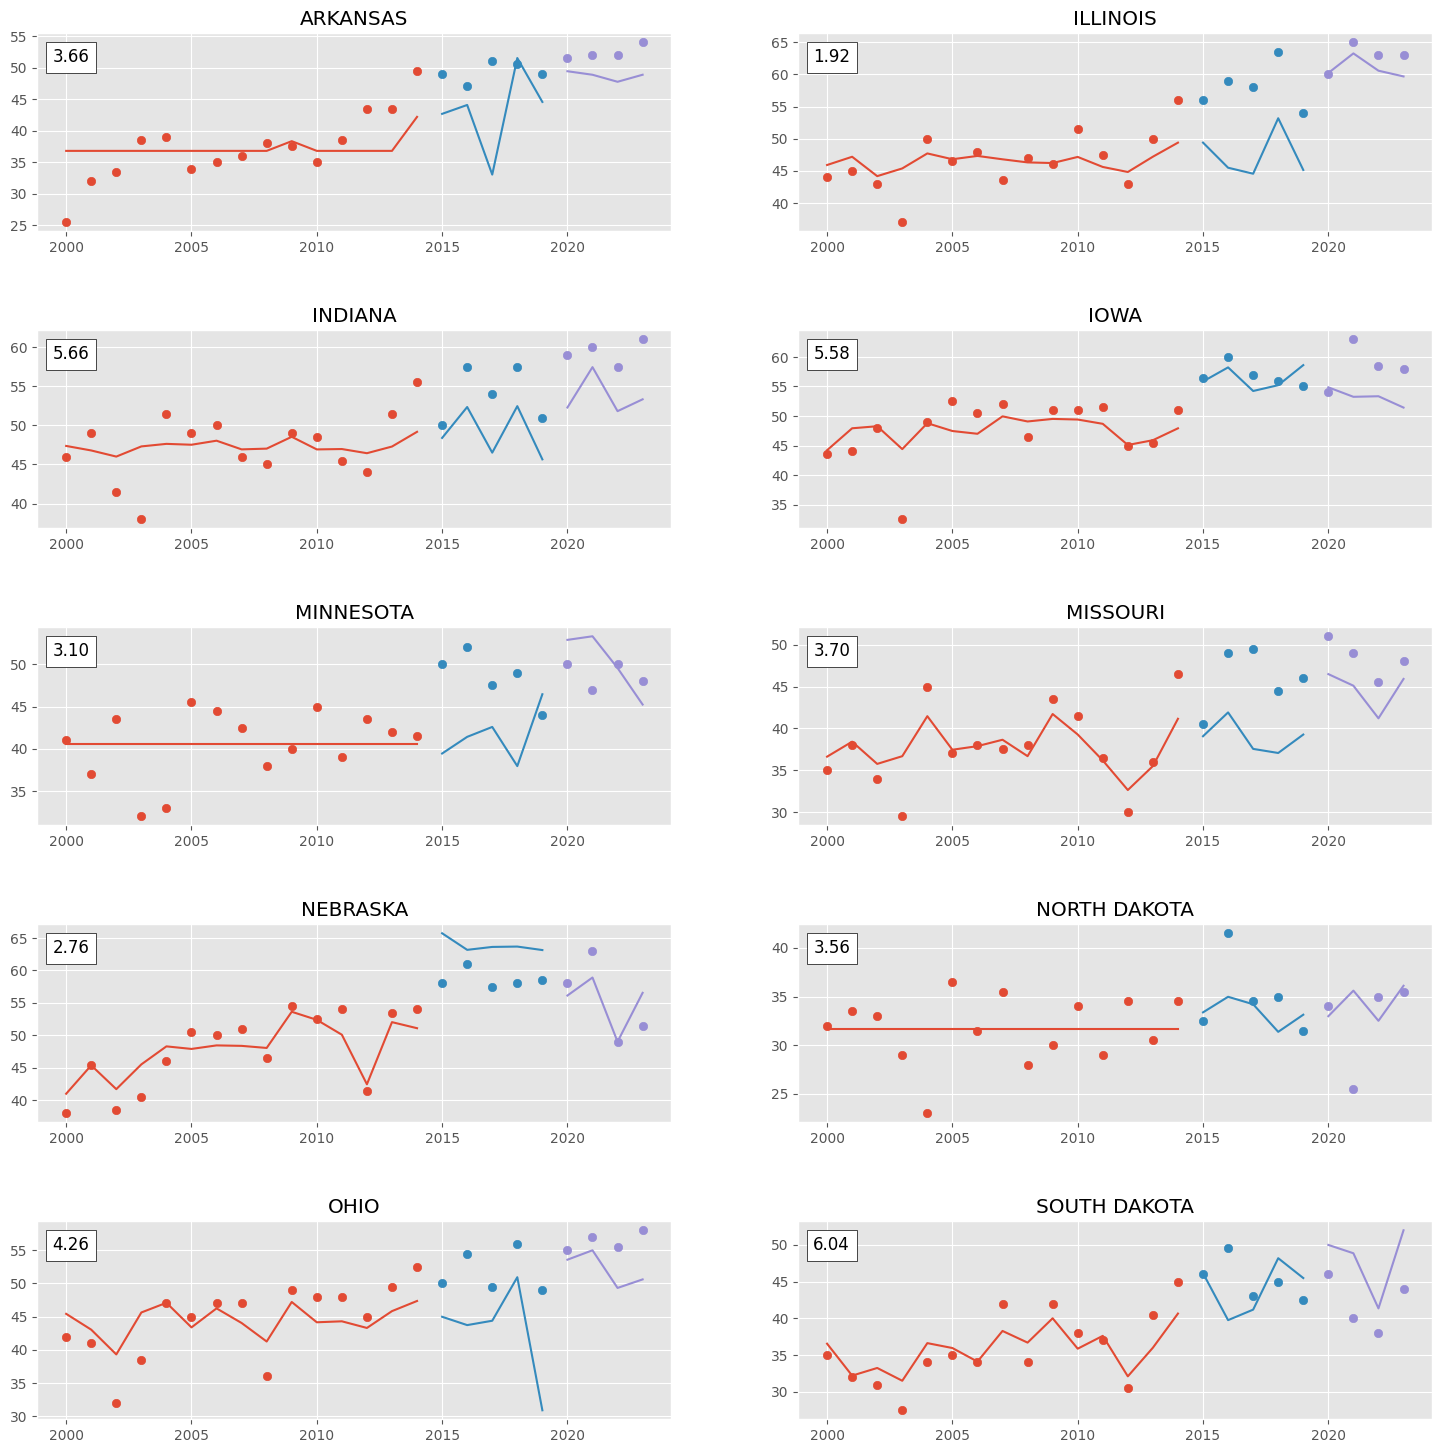

In [132]:

fig, axs = plt.subplots(5, 2, figsize=(18, 18))

for i, ax in enumerate(fig.axes):
    col_name = y.columns[i]
    state_data = x.filter(regex=col_name)
    input = state_data
    if "D1" in x.columns:
        drought_data = x.loc[:, ["D1", "D2", "D3", "D4"]]
        input = pd.concat([input, drought_data], axis=1, ignore_index=False)

    reg_plot(input, y.iloc[:, i], col_name, ax)

plt.subplots_adjust(hspace=0.5)
plt.show()